# Multitask Networks
When we need to make two predictions from the same data, is it better to train two separate networks or to train one multitask network to make these predictions? My initial thought was that it would be best to train separate models, since this allows us to have fewer parameters to train for each task. However, training a multitask network can significantly improve generalization. You can read a paper by Caruana's 1993 paper [here](https://link.springer.com/article/10.1023/A:1007379606734) for more on the subject.

Let's see an example of multitask networks in action using a modified version of one of my projects. The project required making two predictions from the same dataset: classify the binary label "type" and predict the continuous variable "quality". For this example we'll use root mean squared error to evaluate our regression predictions, and we'll use binary cross-entropy to evaluate our class predictions.

Keep in mind that our scores probably won't be great here. The data has been significantly transformed and jittered for privacy, so the features have likely lost a lot of predictive power. Cross-entropy will be particularly harmed, since over 50% of positive labels are unavailable. Because of this we will only look at our cross-entropy score and will not investigate the classification results closely.

Let's complete both tasks individually with single task networks, and then again with a multitask network. Then we'll compare the results of the models on both our validation and test sets. When we do so, we see exactly the results suggested by Caruana.

 

In [1]:
# Import modules.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, log_loss


Init Plugin
Init Graph Optimizer
Init Kernel


In [2]:
# Create global variables.
PATH = '/Users/justinsima/dir/projects/portfolio/multitask/'
DATA_PATH = PATH + 'data/data.csv'


In [3]:
# Load data.
df = pd.read_csv(DATA_PATH)

# Separate into features and labels.
X = df.drop(columns=['type', 'quality'])
Y = df[['type', 'quality']]


In [4]:
# Create train, validation, and test splits.
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.05, random_state=49)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.15, random_state=49)


In [5]:
# Price model constructor.
def build_quality_model():
     # Input layer.
    input_layer = tf.keras.layers.Input(shape=(len(X.columns),))
    
    # Single output layer.
    output_layer = tf.keras.layers.Dense(
        1,
        name='quality_output',
        kernel_regularizer=tf.keras.regularizers.l1(0.01),
        activation='linear'
    )(input_layer)
    
    # Define model.
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model_quality')
    
    # Compile model.
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=tf.keras.metrics.RootMeanSquaredError()
    )
    
    # Display model architecture summary.
    model.summary()

    return model

# Quality model constructor.
def build_type_model():
    # Input layer.
    input_layer = tf.keras.layers.Input(shape=(len(X.columns),))
    
    # Hidden dense layers.
    dense_1 = tf.keras.layers.Dense(9, activation='relu')(input_layer)
    dense_2 = tf.keras.layers.Dense(6, activation='relu')(dense_1)
    dense_3 = tf.keras.layers.Dense(3, activation='relu')(dense_2)
    
    # Output layer.
    output_layer = tf.keras.layers.Dense(1, name='type_output', activation='sigmoid')(dense_3)
    
    # Define model.
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='model_type')
    
    # Compile model.
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=tf.keras.metrics.BinaryCrossentropy()
    )
    
    # Display model architecture summary.
    model.summary()

    return model


In [6]:
# Build model to predict price.
model_type = build_type_model()

# Build model to predict quality.
model_quality = build_quality_model()


Metal device set to: Apple M1
Model: "model_type"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 144       
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
type_output (Dense)          (None, 1)                 4         
Total params: 229
Trainable params: 229
Non-trainable params: 0
_________________________________________________________________
Model: "model_quality"
_________________________________________________________________
Layer

2022-04-10 19:54:23.002958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-10 19:54:23.003060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# Fit price model.
model_type.fit(
    X_train,
    Y_train['type'],
    epochs=40,
    batch_size=32, 
    validation_data=(X_val, Y_val['type']),
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=1e-3,
                                                monitor='val_binary_crossentropy',
                                                patience=10)]
)

# Fit quality model.
model_quality.fit(
    X_train,
    Y_train['quality'],
    epochs=40,
    batch_size=32, 
    validation_data=(X_val, Y_val['quality']),
    callbacks=[tf.keras.callbacks.EarlyStopping(min_delta=1e-3,
                                                monitor='val_root_mean_squared_error',
                                                patience=10)]
)


Epoch 1/40


2022-04-10 19:54:23.071385: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-10 19:54:23.071546: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-10 19:54:23.184462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 3s 6ms/step - loss: 0.6496 - binary_crossentropy: 0.6496 - val_loss: 0.6013 - val_binary_crossentropy: 0.6013
Epoch 2/40
  1/382 [..............................] - ETA: 1s - loss: 0.5836 - binary_crossentropy: 0.5836

2022-04-10 19:54:25.444887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 2s 5ms/step - loss: 0.5614 - binary_crossentropy: 0.5614 - val_loss: 0.5145 - val_binary_crossentropy: 0.5145
Epoch 3/40
382/382 [==============================] - 2s 5ms/step - loss: 0.4984 - binary_crossentropy: 0.4984 - val_loss: 0.4884 - val_binary_crossentropy: 0.4884
Epoch 4/40
382/382 [==============================] - 2s 5ms/step - loss: 0.4804 - binary_crossentropy: 0.4804 - val_loss: 0.4758 - val_binary_crossentropy: 0.4758
Epoch 5/40
382/382 [==============================] - 2s 5ms/step - loss: 0.4679 - binary_crossentropy: 0.4679 - val_loss: 0.4662 - val_binary_crossentropy: 0.4662
Epoch 6/40
382/382 [==============================] - 2s 5ms/step - loss: 0.4599 - binary_crossentropy: 0.4599 - val_loss: 0.4583 - val_binary_crossentropy: 0.4583
Epoch 7/40
382/382 [==============================] - 2s 5ms/step - loss: 0.4545 - binary_crossentropy: 0.4545 - val_loss: 0.4544 - val_binary_crossentropy: 0.4544
Epoch 8/40
382/382 [=======

2022-04-10 19:55:35.502771: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 2s 4ms/step - loss: 0.4862 - root_mean_squared_error: 0.6751 - val_loss: 0.2704 - val_root_mean_squared_error: 0.4950
Epoch 2/40
  1/382 [..............................] - ETA: 1s - loss: 0.4054 - root_mean_squared_error: 0.6164

2022-04-10 19:55:36.870588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 1s 4ms/step - loss: 0.2368 - root_mean_squared_error: 0.4622 - val_loss: 0.1773 - val_root_mean_squared_error: 0.3952
Epoch 3/40
382/382 [==============================] - 1s 4ms/step - loss: 0.1767 - root_mean_squared_error: 0.3969 - val_loss: 0.1439 - val_root_mean_squared_error: 0.3555
Epoch 4/40
382/382 [==============================] - 1s 4ms/step - loss: 0.1558 - root_mean_squared_error: 0.3727 - val_loss: 0.1313 - val_root_mean_squared_error: 0.3395
Epoch 5/40
382/382 [==============================] - 1s 4ms/step - loss: 0.1464 - root_mean_squared_error: 0.3622 - val_loss: 0.1234 - val_root_mean_squared_error: 0.3303
Epoch 6/40
382/382 [==============================] - 1s 4ms/step - loss: 0.1409 - root_mean_squared_error: 0.3567 - val_loss: 0.1188 - val_root_mean_squared_error: 0.3251
Epoch 7/40
382/382 [==============================] - 1s 4ms/step - loss: 0.1386 - root_mean_squared_error: 0.3546 - val_loss: 0.1168 - val_root_mean_s

In [8]:
# Save metrics for both models.
type_results_dict = model_type.evaluate(X_val, Y_val['type'], return_dict=True)
quality_results_dict = model_quality.evaluate(X_val, Y_val['quality'], return_dict=True)


68/68 [==============================] - 0s 3ms/step - loss: 0.1109 - root_mean_squared_error: 0.3160


In [9]:
# Model constructor.
def build_multitask_model():
    # Input layer.
    input_layer = tf.keras.layers.Input(shape=(len(X.columns),))
    
    # Type prediction layers.
    type_dense_1 = tf.keras.layers.Dense(9, activation='relu')(input_layer)
    type_dense_2 = tf.keras.layers.Dense(6, activation='relu')(type_dense_1)
    type_dense_3 = tf.keras.layers.Dense(3, activation='relu')(type_dense_2)
    type_output = tf.keras.layers.Dense(1, activation='sigmoid', name='type_output')(type_dense_3)
    
    # Quality prediction layers.
    quality_output = tf.keras.layers.Dense(
        1,
        kernel_regularizer=tf.keras.regularizers.l1(0.01),
        name='quality_output',
        activation='linear'
    )(input_layer)
    
    # Define model.
    model = tf.keras.Model(
        inputs=input_layer,
        outputs=[type_output, quality_output],
        name='multitask_model'
    )
    
    # Display model summary.
    model.summary()

    return model


In [10]:
# Instantiate model.
multitask_model = build_multitask_model()

# Compile model.
optimizer = tf.keras.optimizers.Adam(0.001)

multitask_model.compile(
    optimizer=optimizer,
    loss={'type_output':'binary_crossentropy', 'quality_output':'mse'},
    metrics={
        'type_output':tf.keras.metrics.BinaryCrossentropy(), 
        'quality_output':tf.keras.metrics.RootMeanSquaredError()
    }
)


Model: "multitask_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 9)            144         input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 6)            60          dense_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 3)            21          dense_4[0][0]                    
____________________________________________________________________________________

In [11]:
# Fit model.
history = multitask_model.fit(
    X_train,
    [Y_train['type'], Y_train['quality']],
    epochs=50,
    batch_size=32, 
    validation_data=(X_val, [Y_val['type'], Y_val['quality']])
)


Epoch 1/50
  8/382 [..............................] - ETA: 2s - loss: 1.9312 - type_output_loss: 0.7132 - quality_output_loss: 1.1823 - type_output_binary_crossentropy: 0.7132 - quality_output_root_mean_squared_error: 1.0874  

2022-04-10 19:56:14.328689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - ETA: 0s - loss: 1.1892 - type_output_loss: 0.6487 - quality_output_loss: 0.5106 - type_output_binary_crossentropy: 0.6487 - quality_output_root_mean_squared_error: 0.7145

2022-04-10 19:56:17.217322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


382/382 [==============================] - 3s 8ms/step - loss: 1.1892 - type_output_loss: 0.6487 - quality_output_loss: 0.5106 - type_output_binary_crossentropy: 0.6487 - quality_output_root_mean_squared_error: 0.7145 - val_loss: 0.8852 - val_type_output_loss: 0.6099 - val_quality_output_loss: 0.2486 - val_type_output_binary_crossentropy: 0.6099 - val_quality_output_root_mean_squared_error: 0.4986
Epoch 2/50
382/382 [==============================] - 3s 7ms/step - loss: 0.7844 - type_output_loss: 0.5721 - quality_output_loss: 0.1878 - type_output_binary_crossentropy: 0.5721 - quality_output_root_mean_squared_error: 0.4333 - val_loss: 0.6757 - val_type_output_loss: 0.5132 - val_quality_output_loss: 0.1397 - val_type_output_binary_crossentropy: 0.5132 - val_quality_output_root_mean_squared_error: 0.3738
Epoch 3/50
382/382 [==============================] - 3s 8ms/step - loss: 0.6542 - type_output_loss: 0.4948 - quality_output_loss: 0.1378 - type_output_binary_crossentropy: 0.4948 - quali

Epoch 21/50
382/382 [==============================] - 3s 8ms/step - loss: 0.5712 - type_output_loss: 0.4379 - quality_output_loss: 0.1220 - type_output_binary_crossentropy: 0.4379 - quality_output_root_mean_squared_error: 0.3492 - val_loss: 0.5512 - val_type_output_loss: 0.4381 - val_quality_output_loss: 0.1019 - val_type_output_binary_crossentropy: 0.4381 - val_quality_output_root_mean_squared_error: 0.3192
Epoch 22/50
382/382 [==============================] - 3s 7ms/step - loss: 0.5711 - type_output_loss: 0.4372 - quality_output_loss: 0.1225 - type_output_binary_crossentropy: 0.4372 - quality_output_root_mean_squared_error: 0.3500 - val_loss: 0.5498 - val_type_output_loss: 0.4373 - val_quality_output_loss: 0.1015 - val_type_output_binary_crossentropy: 0.4373 - val_quality_output_root_mean_squared_error: 0.3185
Epoch 23/50
382/382 [==============================] - 3s 8ms/step - loss: 0.5702 - type_output_loss: 0.4367 - quality_output_loss: 0.1223 - type_output_binary_crossentropy: 

Epoch 41/50
382/382 [==============================] - 3s 7ms/step - loss: 0.5641 - type_output_loss: 0.4310 - quality_output_loss: 0.1221 - type_output_binary_crossentropy: 0.4310 - quality_output_root_mean_squared_error: 0.3494 - val_loss: 0.5484 - val_type_output_loss: 0.4370 - val_quality_output_loss: 0.1002 - val_type_output_binary_crossentropy: 0.4370 - val_quality_output_root_mean_squared_error: 0.3166
Epoch 42/50
382/382 [==============================] - 3s 7ms/step - loss: 0.5637 - type_output_loss: 0.4305 - quality_output_loss: 0.1221 - type_output_binary_crossentropy: 0.4305 - quality_output_root_mean_squared_error: 0.3494 - val_loss: 0.5477 - val_type_output_loss: 0.4363 - val_quality_output_loss: 0.1003 - val_type_output_binary_crossentropy: 0.4363 - val_quality_output_root_mean_squared_error: 0.3168
Epoch 43/50
382/382 [==============================] - 3s 7ms/step - loss: 0.5632 - type_output_loss: 0.4301 - quality_output_loss: 0.1220 - type_output_binary_crossentropy: 

In [12]:
# Save multitask model results.
multitask_results_dict = multitask_model.evaluate(X_val, [Y_val['type'], Y_val['quality']], return_dict=True)


68/68 [==============================] - 0s 5ms/step - loss: 0.5481 - type_output_loss: 0.4371 - quality_output_loss: 0.1002 - type_output_binary_crossentropy: 0.4371 - quality_output_root_mean_squared_error: 0.3165


In [13]:
# Save results as a dataframe.
df_val_results = pd.DataFrame([
    [quality_results_dict['root_mean_squared_error'], type_results_dict['loss']],
    [multitask_results_dict['quality_output_root_mean_squared_error'], multitask_results_dict['type_output_binary_crossentropy']]
])
df_val_results.columns = ['RMSE', 'Binary Cross-Entropy']
df_val_results.index = ['Single Task Models', 'Multitask Model']

# Display dataframe.
df_val_results


,RMSE,Binary Cross-Entropy
Single Task Models,0.316009,0.442401
Multitask Model,0.316536,0.437126


In [14]:
# Make predictions on test set.
type_pred_arrays = model_type.predict(X_test)
type_preds = np.asarray([pred[0] for pred in type_pred_arrays])

quality_pred_arrays = model_quality.predict(X_test)
quality_preds = np.asarray([pred[0] for pred in quality_pred_arrays])

multi_preds = multitask_model.predict(X_test)
multitask_type_preds = np.asarray([pred[0] for pred in multi_preds[0]])
multitask_quality_preds = np.asarray([pred[0] for pred in multi_preds[1]])

# Store observed values for test set.
type_obs = Y_test['type']
quality_obs = Y_test['quality']

# Store residuals.
multitask_price_res = type_obs - multitask_type_preds

quality_res = quality_obs - quality_preds
multitask_quality_res = quality_obs - multitask_quality_preds


2022-04-10 19:58:38.668264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:58:38.733236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-04-10 19:58:38.774488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


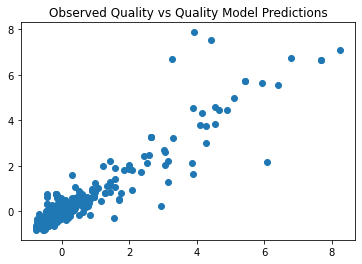

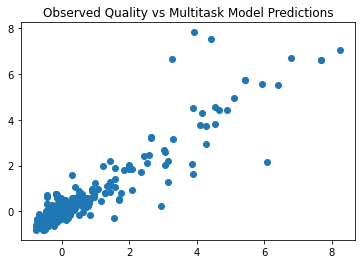

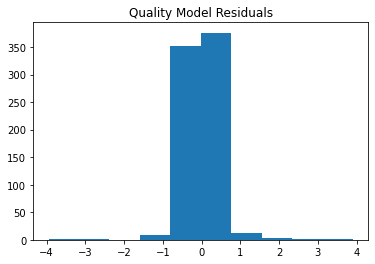

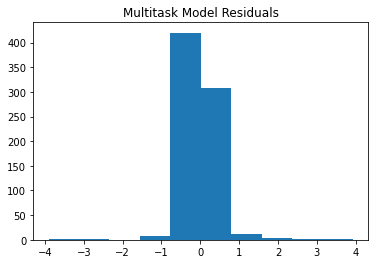


Quality Model MSE: 0.16665343088383774
Multitask Model MSE: 0.16659926189459304


Type Model Cross-Entropy: 0.44111710791123926
Multitask Model Cross-Entropy: 0.43721100612709046



In [33]:
# Compare quality predictions for both models.

# Plot predicrted vs observed quality.
plt.scatter(quality_obs, quality_preds)
plt.title('Observed Quality vs Quality Model Predictions')
plt.show()

plt.scatter(quality_obs, multitask_quality_preds)
plt.title('Observed Quality vs Multitask Model Predictions')
plt.show()

# Plot residuals.
plt.hist(quality_res)
plt.title('Quality Model Residuals')
plt.show()

plt.hist(multitask_quality_res)
plt.title('Multitask Model Residuals')
plt.show()

# Calculate and display mean squared error.
mse_quality = mean_squared_error(quality_obs, quality_preds)
mse_multitask = mean_squared_error(quality_obs, multitask_quality_preds)

print()
print(f'Quality Model MSE: {mse_quality}')
print(f'Multitask Model MSE: {mse_multitask}')
print()

# Calculate and display log-loss.
entropy_type = log_loss(type_obs, type_preds, eps=1e-7)
entropy_multitask = log_loss(type_obs, multitask_type_preds)

print()
print(f'Type Model Cross-Entropy: {entropy_type}')
print(f'Multitask Model Cross-Entropy: {entropy_multitask}')
print()




There you have it! The results might night be mindblowing right now (the finished project required not only the use of multitask learning, but also some nested frozen networks), but this example does show that we can get better results using a multitask network as opposed to training two models separately. Not only does this allow models to generalize more easily, but it can also make deploying your models much simpler.
